## **Final Optimised Version**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Original data loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203126 entries, 0 to 203125
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   status        203126 non-null  object 
 1   price         203126 non-null  float64
 2   bed           171963 non-null  float64
 3   bath          172835 non-null  float64
 4   acre_lot      151066 non-null  float64
 5   full_address  203126 non-null  object 
 6   street        203041 non-null  object 
 7   city          203074 non-null  object 
 8   state         203126 non-null  object 
 9   zip_code      202931 non-null  float64
 10  house_size    173448 non-null  float64
 11  sold_date     75339 non-null   object 
dtypes: float64(6), object(6)
memory usage: 18.6+ MB
Dropped columns: ['full_address', 'street', 'sold_date',

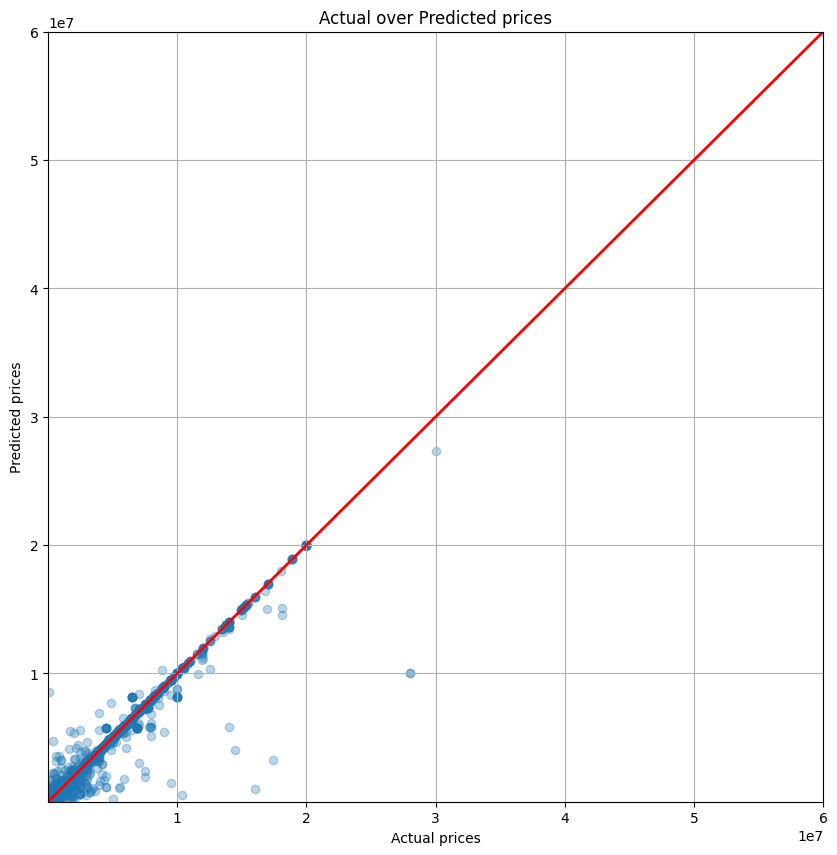

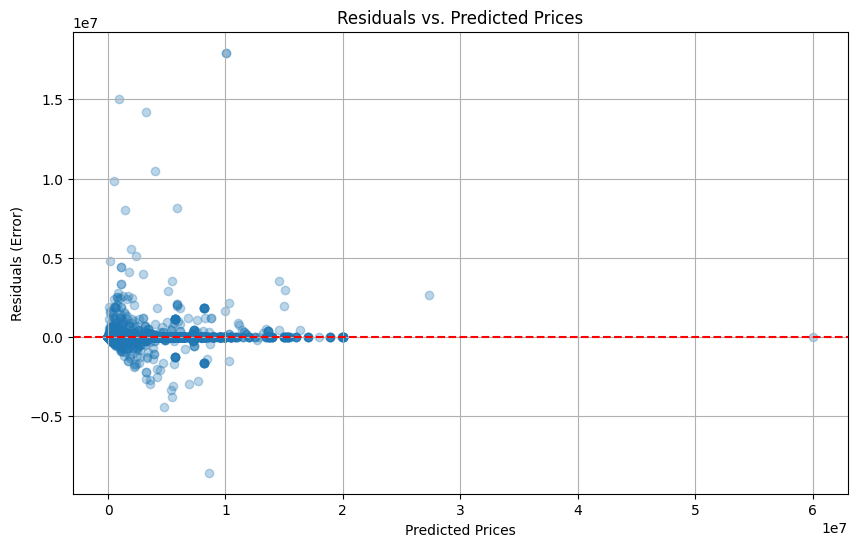

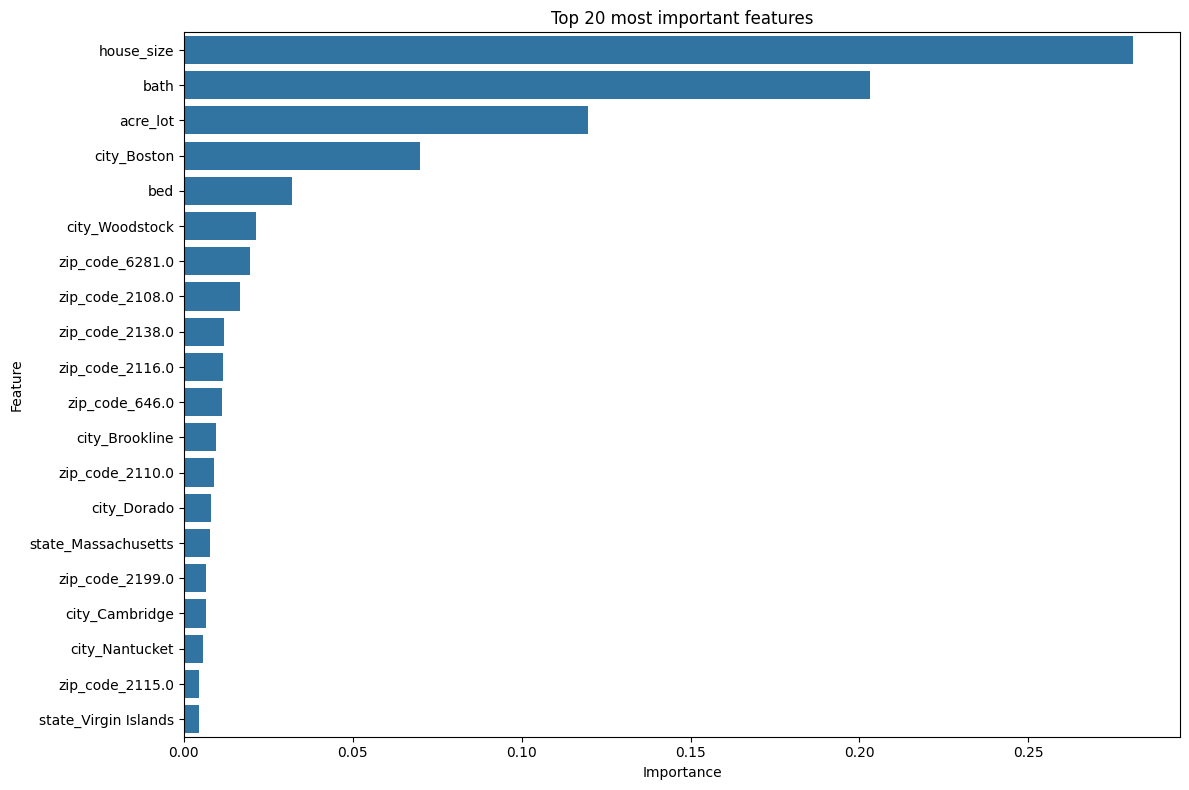

In [3]:
#preping data for ml model(s)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns # Added for the feature importance plot
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error, r2_score

from google.colab import drive
drive.mount('/content/drive')


def preprocess_real_estate_data(df, target_column='price'):

    # Droping irrelevant columns
    columns_to_drop = ['full_address', 'street', 'sold_date', 'status']
    columns_to_drop = [col for col in columns_to_drop if col in df.columns]
    if columns_to_drop:
        df = df.drop(columns=columns_to_drop)
        print(f"Dropped columns: {columns_to_drop}")
    else:
        print("Not found.")

    #numerical and categorical features
    feature_columns = [col for col in df.columns if col != target_column] if target_column else df.columns.tolist()

    numerical_features = []
    categorical_features = []

    #loop though to assign as num or cat
    for col in feature_columns:
        if df[col].dtype in ['int64', 'float64']:
            if col in ['bed', 'bath', 'acre_lot', 'house_size']: # true numericals
                 numerical_features.append(col)
            elif col == 'zip_code': # zip_code is categorical
                 df[col] = df[col].astype(str) #converting to string
                 categorical_features.append(col)
            elif col != target_column : # other numerical
                 numerical_features.append(col)
        else: # categorical
            categorical_features.append(col)
            df[col] = df[col].astype(str) # ensure string type for OHE

    # Separating Target Variable (if specified)
    y = None
    if target_column and target_column in df.columns:
        y = df[target_column]
        X = df[feature_columns].copy() #(SettingWithCopyWarning)
        print(f"'{target_column}' separated.")
    elif target_column:
        raise ValueError(f"Target column '{target_column}' not found in DataFrame.")
    else: # no target specified
        X = df.copy()
        print("No target, processing entire DF as features.")

    # Create Preprocessing Pipelines
    # Numerical pipeline. median imputation and scaling
    numerical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Categorical pipeline.Imputw with 'missing' and OneHotEncode
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)) # Dense array output
    ])

    # Apply transformers to columns
    final_numerical_features = [f for f in numerical_features if f in X.columns]
    final_categorical_features = [f for f in categorical_features if f in X.columns]

    transformers_list = []
    if final_numerical_features:
        transformers_list.append(('num', numerical_pipeline, final_numerical_features))
    if final_categorical_features:
        transformers_list.append(('cat', categorical_pipeline, final_categorical_features))

    preprocessor = ColumnTransformer(transformers=transformers_list, remainder='passthrough')

    #Apply prep
    X_processed_np = preprocessor.fit_transform(X)

    # Convert processed data back to df
    # reconstruct DataFrame with new feature names from ohe.
    processed_feature_names = []
    if 'num' in preprocessor.named_transformers_ and final_numerical_features:
        processed_feature_names.extend(final_numerical_features) # Numerical names remain

    if 'cat' in preprocessor.named_transformers_ and final_categorical_features:
        try:
            onehot_cols = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(final_categorical_features)
            processed_feature_names.extend(onehot_cols)
        except KeyError:
             print("Categorical transformer 'cat' not found.")


    X_processed = pd.DataFrame(X_processed_np, columns=processed_feature_names, index=X.index)

    print(f"Preprocessing complete. Shape: {X_processed.shape}")

    if target_column:
        return X_processed, y
    else:
        return X_processed


'''
Main Execution Block.

This part of the script loads the original data, preprocesses it,
trains the model, and visualizes the results all in one flow.
'''


# Path to the ORIGINAL small data file
data_file_path = "/content/drive/My Drive/ML_project/ML_Project/Random Forest Regressor module - Final/2 realtor-data.csv"

#Load data
try:
    df_loaded = pd.read_csv(data_file_path)
    print("Original data loaded successfully.")
    df_loaded.info()

    #Predicting 'price' by calling the preprocessing function
    X, y = preprocess_real_estate_data(df_loaded, target_column='price')


    '''
    This is the start of the logic from the second cell.
    Main script and ml training.
    '''


    # separate X and Y is already done by the function above

    print("\n")
    print(X.shape)
    print(y.shape)

    #Initialize model and task type
    # Using n_jobs=-1 to use all available CPU cores
    model = RandomForestRegressor(random_state=42, n_jobs=-1)
    #to do: more regression models(if needed)

    # Split data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"X_train {X_train.shape}, y_train {y_train.shape}")
    print(f"X_test {X_test.shape}, y_test {y_test.shape}")

    # Train the model
    print("\n")
    print("Starting model training (this may take a while)...")
    model.fit(X_train, y_train)
    print("Training complete!")

    # Evaluate the model
    y_pred = model.predict(X_test)

    # print RMSE and R2 score
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R2 Score): {r2:.4f}")


    '''Below is everything for visualization'''


    # actual over predicted prices
    plt.figure(figsize=(10, 10))
    plt.scatter(y_test, y_pred, alpha=0.3)
    lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
    plt.plot(lims, lims, 'r-', linewidth=2)
    plt.xlabel("Actual prices")
    plt.ylabel("Predicted prices")
    plt.title("Actual over Predicted prices")
    plt.xlim(lims)
    plt.ylim(lims)
    plt.grid(True)
    plt.savefig('actual_over_predicted.png')
    plt.show() #For colab or Jupiter Notebook

    # Residuals plot
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred, residuals, alpha=0.3)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Predicted Prices")
    plt.ylabel("Residuals (Error)")
    plt.title("Residuals vs. Predicted Prices")
    plt.grid(True)
    plt.savefig('residuals_plot.png')
    plt.show()

    # Importance of the features
    importances = model.feature_importances_
    feature_names = X_train.columns
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
    plt.title('Top 20 most important features')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    plt.show()

except FileNotFoundError:
    print(f"'{data_file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")